In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from matplotlib.ticker import MaxNLocator
import json
import ptitprince as pt
import pickle as pkl
# import contextily as ctx
from src.data.analyse import *
from ema_workbench import load_results
sns.set_theme(style="ticks")

## Model functions

In [4]:
country = 'Saint Lucia'
household_survey = pd.read_csv(f'../data/processed/household_survey/{country}/{country}.csv')

### _assign_savings()

It seems that what we do here is define a multiplier `m` for the product of `aaexp` and `saving_rate`. This multiplier has a (random) mean with uniform distribution from 0 to 5 scale=2.5 and normally distributed. On top of that we clip it between 0 and 1.     

In [5]:
saving_rate = 0.02385
df = household_survey.eval(f'aeexp*{saving_rate}').to_frame()
df.columns = ['aeexp*saving_rate']

loc = np.random.uniform(0, 5)
scale = 2.5
size = df.shape[0]
clip_min = 0 
clip_max = 1
m = np.random.normal(loc, scale, size).round(2).clip(min=clip_min, max=clip_max)
df['aesav'] = df['aeexp*saving_rate'] * m

In [6]:
# Let's sample it for a couple of times
low = 0
high = 5
scale = 2.5
size = df.shape[0]
clip_min = 0 
clip_max = 1

clipped = []
unclipped = []
n = 1000
for i in range(0,n):
    loc = np.random.uniform(low, high)
    m = np.random.normal(loc, scale, size).round(2) # .clip(min=clip_min, max=clip_max)
    unclipped.append(m)
    clipped.append(m.clip(min=clip_min, max=clip_max))
clipped = pd.DataFrame(clipped).T
unclipped = pd.DataFrame(unclipped).T

The resulting distribution is skewed. It has a much number of observations around 0 and 1.

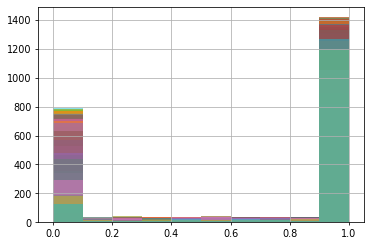

In [7]:
fig, ax = plt.subplots()
for i in range(n):
    clipped.iloc[:,i].hist(ax=ax, label='clipped', alpha=0.5, bins=10)

In [8]:
value_counts = clipped.apply(lambda x: x.value_counts(), axis=0).mean(axis=1).sort_values()

In [9]:
value_counts / value_counts.sum()

0.01    0.001298
0.02    0.001307
0.10    0.001311
0.09    0.001322
0.38    0.001325
          ...   
0.74    0.001483
0.96    0.001501
0.87    0.001518
0.00    0.191387
1.00    0.671099
Length: 101, dtype: float64

Thus, most of the values (**66%**) won't be changed, other **20%** turned to 0 and the rest (**14%**) will become smaller. As a result we have quite some difference between `aesav` and `aeexp`*`saving_rate`. Let's see how this affects the distribution of the two variables.

In [10]:
df['mean_sample'] = df['aeexp*saving_rate'] * clipped.mean(axis=1)

In [11]:
(df['aesav'] - df['mean_sample']).describe()

count    1493.000000
mean       81.704439
std       191.741881
min     -4270.820439
25%        38.775230
50%        65.812316
75%       109.708335
max      3670.696585
dtype: float64

In [14]:
melted = pd.melt(df, value_vars=['aeexp*saving_rate', 'aesav', 'mean_sample'], var_name='variable', value_name='value')

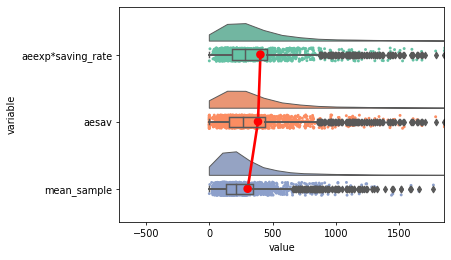

In [15]:
ax = pt.RainCloud(x='variable', y='value', data=melted, palette='Set2', 
             bw=0.2, width_viol=.7, orient='h', pointplot=True, cut=0);
ax.set_xlim(right=melted['value'].quantile(0.99));

### _set_vulnerability()

In [16]:
df = household_survey['v_init'].to_frame()

In [25]:
# Let's take a look at a single sample
low = 0.6
high = 1.4
df['v'] = df['v_init'] * np.random.uniform(low, high, df.shape[0])
threshold = 0.95
df.loc[df['v'] > threshold, 'v'] = threshold

# And now let's take average over 1000 samples
sample = []
n = 100
for i in range(n):
    sample.append(np.random.uniform(low, high, df.shape[0]))
sample = pd.DataFrame(sample)
mean_sample = sample.mean(axis=0)
df['mean_sample'] = df['v_init'] * mean_sample
df.loc[df['mean_sample'] > threshold, 'mean_sample'] = threshold

In [26]:
df

,v_init,v,mean_sample
0,0.500,0.572668,0.512613
1,0.550,0.339372,0.556327
2,0.425,0.458019,0.418115
3,0.425,0.562654,0.416849
4,0.500,0.558372,0.496112
...,...,...,...
1488,0.500,0.601150,0.508003
1489,0.550,0.726084,0.558168
1490,0.425,0.542277,0.403308
1491,0.600,0.701052,0.598528


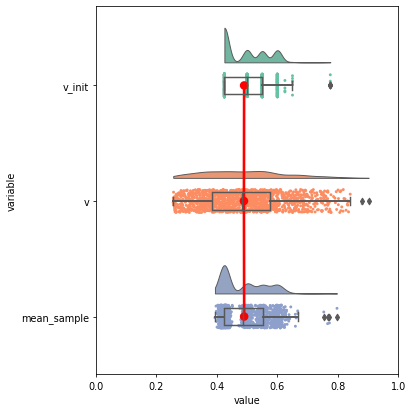

In [27]:
plt.figure(figsize=(6,6))
melted = pd.melt(df, value_vars=['v_init', 'v', 'mean_sample'], var_name='variable', value_name='value')
ax = pt.RainCloud(x='variable', y='value', data=melted, palette='Set2', 
             bw=0.2, width_viol=0.6, orient='h', pointplot=True, cut=0)
ax.set_xlim(0, 1)
plt.tight_layout()

### assign_savings()

### calculate_recovery_rate()

### integrate_wellbeing()

## Model outcomes

### Correlation analysis

In [4]:
# Load results
n_scenarios = 1000
n_policies = 0
income_loss = False
results = load_results(f'../results/scenarios={n_scenarios}, policies={n_policies}, income_loss={income_loss}.tar.gz')

# Prepare outcomes
outcomes = prepare_outcomes(results, add_policies=False)

In [5]:
outcomes_of_interest = ['total_asset_loss', 
                        'total_consumption_loss', 
                        'n_affected_people',
                        'new_poverty_gap',
                        'annual_average_consumption_loss',
                        'annual_average_consumption_loss_pct',
                        'r'
                        ]

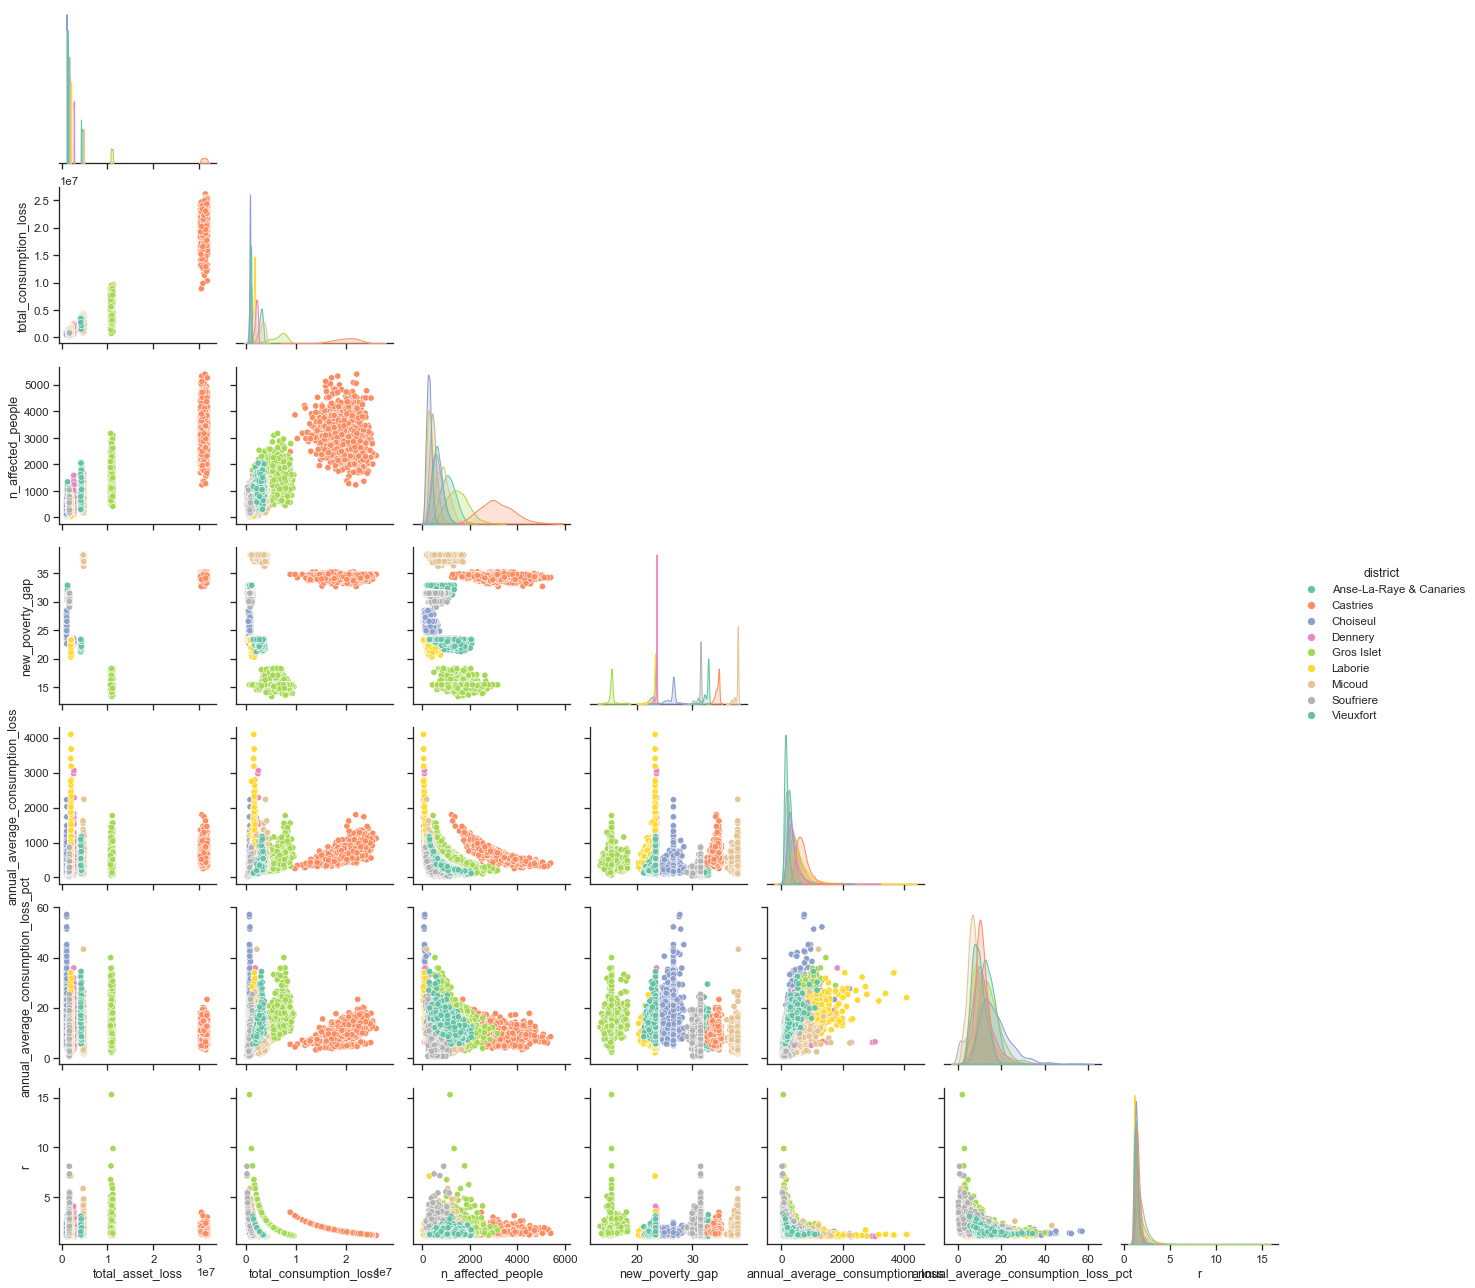

In [6]:
df = outcomes[['district'] + outcomes_of_interest]
sns.pairplot(df, hue='district', palette='Set2', corner=True);

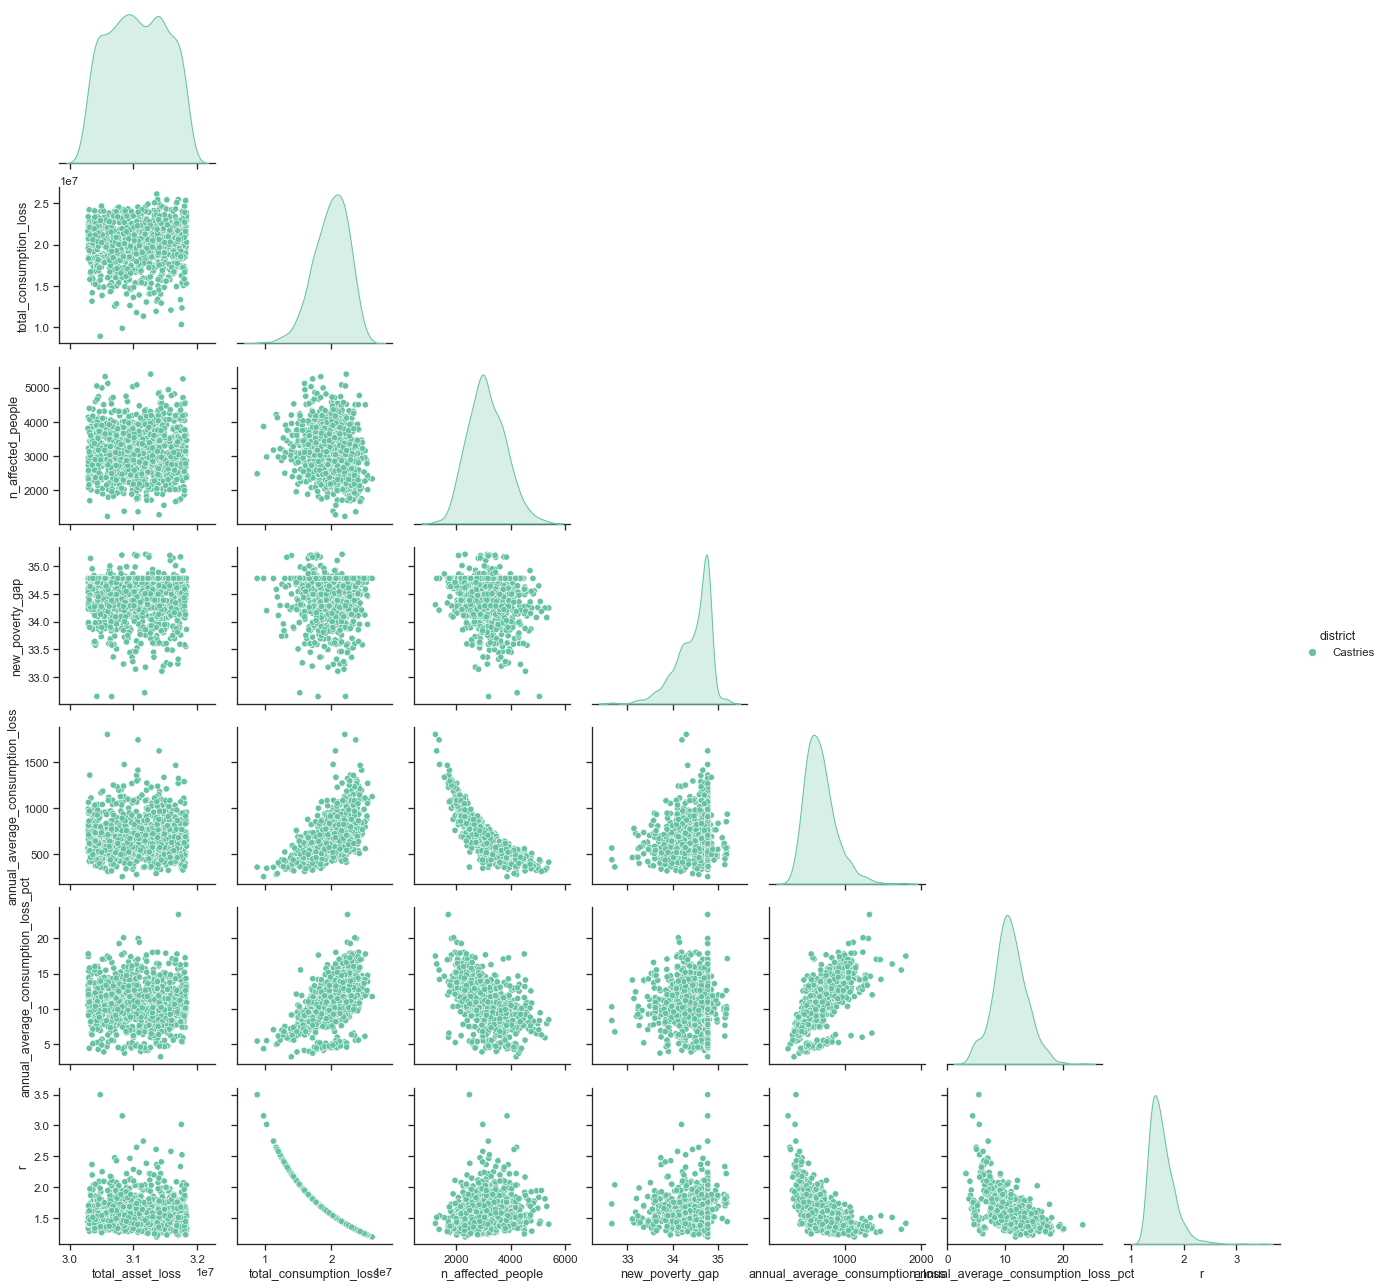

In [7]:
df = outcomes[['district'] + outcomes_of_interest]
sns.pairplot(df[df['district'] == 'Castries'], hue='district', palette='Set2', corner=True);

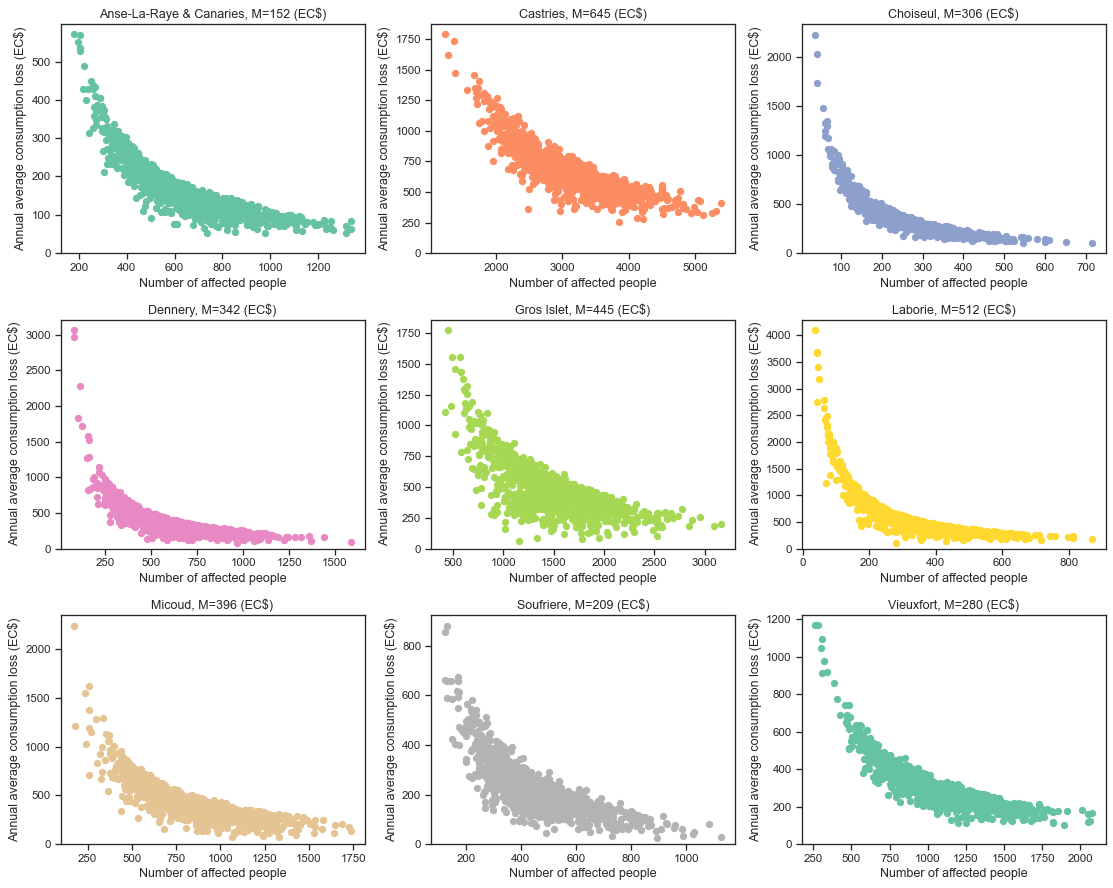

In [8]:
districts = outcomes['district'].unique().tolist()
n_districts = len(districts)
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5 * n_districts / 3, 4 * n_districts / 3), sharex=False, sharey=False)
colors = sns.color_palette('Set2', n_colors=len(districts))

for district in districts:
    df = outcomes[outcomes['district'] == district]
    i = districts.index(district) // 3
    j = districts.index(district) % 3
    color = colors[districts.index(district)]
    x = df['n_affected_people']
    y = df['annual_average_consumption_loss']
    ax[i, j].scatter(x, y, color=color)
    ax[i, j].set_xlabel('Number of affected people')
    ax[i, j].set_ylabel('Annual average consumption loss (EC$)')
    ax[i, j].set_ylim(0)
    ax[i, j].set_title(f'{district}, M={df["annual_average_consumption_loss"].median():.0f} (EC$)')

fig.tight_layout();

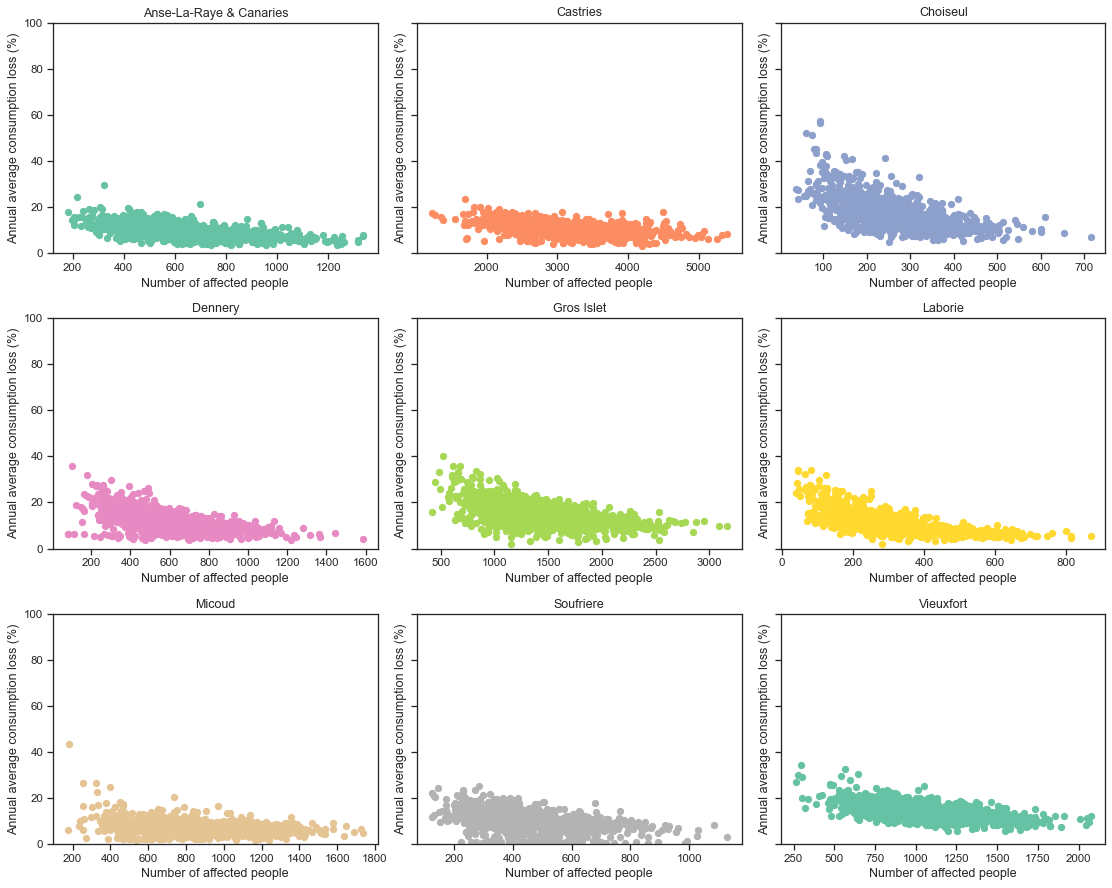

In [9]:
districts = outcomes['district'].unique().tolist()
n_districts = len(districts)
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5 * n_districts / 3, 4 * n_districts / 3), sharex=False, sharey=True)
colors = sns.color_palette('Set2', n_colors=len(districts))

for district in districts:
    df = outcomes[outcomes['district'] == district]
    i = districts.index(district) // 3
    j = districts.index(district) % 3
    color = colors[districts.index(district)]
    x = df['n_affected_people']
    y = df['annual_average_consumption_loss_pct']
    ax[i, j].scatter(x, y, color=color)
    ax[i, j].set_xlabel('Number of affected people')
    ax[i, j].set_ylabel('Annual average consumption loss (%)')
    ax[i, j].set_ylim(0, 100)
    ax[i, j].set_title(district)

fig.tight_layout();

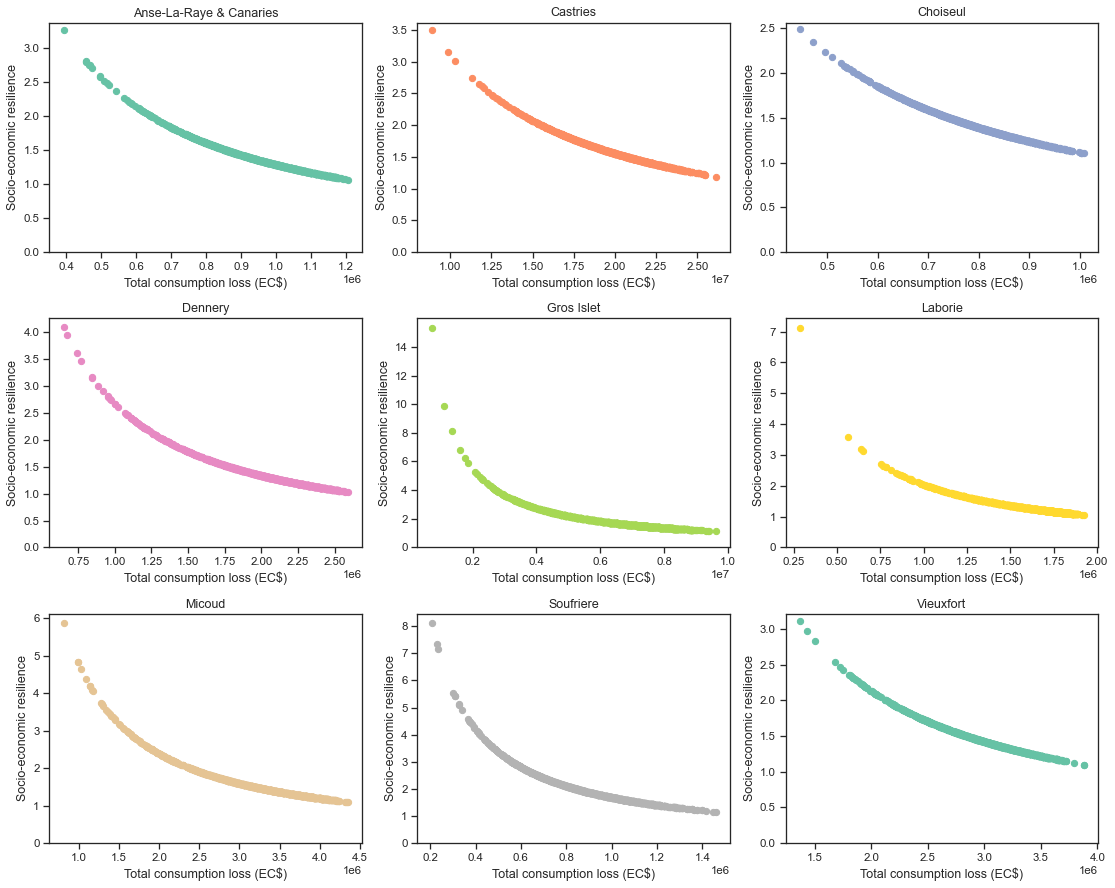

In [13]:
districts = outcomes['district'].unique().tolist()
n_districts = len(districts)
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5 * n_districts / 3, 4 * n_districts / 3), sharex=False, sharey=False)
colors = sns.color_palette('Set2', n_colors=len(districts))

for district in districts:
    df = outcomes[outcomes['district'] == district]
    i = districts.index(district) // 3
    j = districts.index(district) % 3
    color = colors[districts.index(district)]
    x = df['total_consumption_loss']
    y = df['r']
    ax[i, j].scatter(x, y, color=color)
    ax[i, j].set_xlabel('Total consumption loss (EC$)')
    ax[i, j].set_ylabel('Socio-economic resilience')
    ax[i, j].set_ylim(0)
    ax[i, j].set_title(district)

fig.tight_layout();

### determine_affected()

One of the main parameters of the `determine_affected` function is `delta_pct`. This parameter allows for a certain deviation from the initial PML. The more the `delta_pct`, the more can be the deviation. For example, if we have a PML = 1,000,000, `delta_pct` of 0.025 would mean that we allow 2.5% = +- 25,000 deviations when searching for (number of) `affected_households`. (When we sum the impact made to `affected_households` it must be equal to PML +- (PML * `delta_pct`))

Let's explore the effect of `delta_pct` of 0.025, 0.05 and 0.1 on a couple of model outcomes: `annual_average_consumption_loss_pct` and `r`.

In [24]:
# Load results
n_scenarios = 100
n_policies = 0
delta_0025 = load_results(f'../results/scenarios={n_scenarios}, policies={n_policies}, delta_pct=0.025.tar.gz')
delta_005 = load_results(f'../results/scenarios={n_scenarios}, policies={n_policies}, delta_pct=0.05.tar.gz')
delta_01 = load_results(f'../results/scenarios={n_scenarios}, policies={n_policies}, delta_pct=0.1.tar.gz')

delta_0025 = prepare_outcomes(delta_0025, add_policies=False)
delta_005 = prepare_outcomes(delta_005, add_policies=False)
delta_01 = prepare_outcomes(delta_01, add_policies=False)

numeric_columns = delta_0025.columns[3:-1].tolist()
delta_0025[numeric_columns] = delta_0025[numeric_columns].apply(pd.to_numeric)
delta_005[numeric_columns] = delta_005[numeric_columns].apply(pd.to_numeric)
delta_01[numeric_columns] = delta_01[numeric_columns].apply(pd.to_numeric)

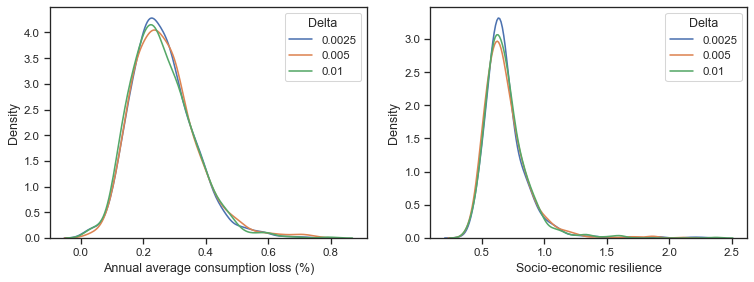

In [50]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))

outcome_of_interests = ['annual_average_consumption_loss_pct', 'r']
x_labels = ['Annual average consumption loss (%)', 'Socio-economic resilience']
for i, outcome_of_interest in enumerate(outcome_of_interests):
    sns.kdeplot(
        data=delta_0025, x=outcome_of_interest, ax=ax[i], label='0.0025'
    )
    sns.kdeplot(
        data=delta_005, x=outcome_of_interest, ax=ax[i], label='0.005'
    )
    sns.kdeplot(
        data=delta_01, x=outcome_of_interest, ax=ax[i], label='0.01'
    )
    ax[i].legend(title='Delta')
    ax[i].set_xlabel(x_labels[i])

In [47]:
outcome_of_interest = 'annual_average_consumption_loss_pct'
df = pd.concat([delta_0025[outcome_of_interest],
                delta_005[outcome_of_interest],
                delta_01[outcome_of_interest],], axis=1)
df.columns = ['0.0025', '0.005', '0.01']
df.describe()

,0.0025,0.005,0.01
count,900.000000,900.000000,900.000000
mean,0.260510,0.266858,0.258813
std,0.098188,0.104235,0.100674
min,0.022438,0.028016,0.029102
25%,0.191780,0.191937,0.188748
50%,0.250042,0.253736,0.245444
75%,0.316680,0.318713,0.317640
max,0.711280,0.752673,0.791487


In [48]:
outcome_of_interest = 'r'
df = pd.concat([delta_0025[outcome_of_interest],
                delta_005[outcome_of_interest],
                delta_01[outcome_of_interest],], axis=1)
df.columns = ['0.0025', '0.005', '0.01']
df.describe()

,0.0025,0.005,0.01
count,900.000000,900.000000,900.000000
mean,0.688589,0.691932,0.689573
std,0.178661,0.187610,0.175230
min,0.339930,0.373847,0.376832
25%,0.585109,0.575831,0.584440
50%,0.651995,0.651264,0.658728
75%,0.745303,0.762658,0.759665
max,2.251408,2.094631,2.372459


### "Dynamic policy"

Next we are going to check how "dynamic policy" works. A dynamic policy is a cash transfer at a certain time added to `aesav` of affected households. Note that there could be multiple transfers at different times. Let's look at how their consumption restores over time.

In [49]:
with open('..results/household_consumption/consumption_recovery.pickle', 'rb') as handle:
    consumption_recovery = pkl.load(handle)
consumption_recovery = pd.DataFrame(dict(consumption_recovery))

It seems that the dynamic policy works. Household consumption increase at the given times and continues to grow.

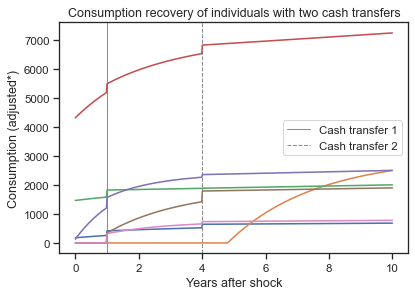

In [52]:
fig, ax = plt.subplots()

# We tested two cash transfers, one at 1 year and one at 4 years
x = [52, 208]
transfer_times = consumption_recovery.columns[x].tolist()

linestyles = ['-', '--']
for i, t in enumerate(transfer_times):
    ax.axvline(t, color='k', linestyle=linestyles[i], linewidth=1, alpha=0.5)
plt.legend(['Cash transfer 1', 'Cash transfer 2'])

consumption_recovery.T.plot(ax=ax, legend=False)

# * Note that these are not the "real" consumption values, we adjusted expenditure to match the asset damage data
plt.ylabel('Consumption (adjusted*)')
plt.xlabel('Years after shock')
plt.title('Consumption recovery of individuals with two cash transfers');